In [1]:
import seaborn as sns 
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("weather_data.csv")

cols = ["YEAR", "MO", "DY"]
data["DATE"] = data[cols].apply(lambda row: "-".join(row.values.astype(str)), axis=1)

data.set_index("DATE", inplace = True)
useless = ["LAT", "LON", "YEAR", "MO", "DY"]
df = data.drop(useless, axis = 1)
df.head()

,T2M_MAX,T2M_MIN,T2M
DATE,,,
2010-1-1,11.84,-0.24,6.13
2010-1-2,13.78,3.74,7.89
2010-1-3,6.90,1.20,3.35
2010-1-4,2.67,-4.31,-0.11
2010-1-5,3.17,-4.42,-1.90


In [3]:
max_temp = df["T2M_MAX"]
min_temp = df["T2M_MIN"]
avg_temp = df["T2M"]

In [4]:
## hyperparameter optimization

In [5]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print("pdq's: ", list(itertools.product(p, d, q)))
print("seasonal pdq's: ", [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))])

pdq's:  [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal pdq's:  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [6]:
# Akaike Information Criterion as AIC
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(avg_temp,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))            
        except:
            continue        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14827.5991214257
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13172.576922325065
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10597.568057470819
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10403.677073077193
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10557.484143939657
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10448.982494153815
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10381.454386130876
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10369.65328384643
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:12538.485590625125
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:11099.368627021304
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9132.813427975248
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8851.816499532168
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9077.782108406775
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9088.09234865885
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:8851.256365699373
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8830.063598143885
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:7611.176140185284
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:7551.093606071359
ARIM

In [7]:
# ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:7446.378104733363 is the lowest and so, the best

In [8]:
mod = sm.tsa.statespace.SARIMAX(avg_temp,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3342      0.068     -4.880      0.000      -0.468      -0.200
ma.L1          0.5651      0.061      9.316      0.000       0.446       0.684
ma.S.L12       0.0413      0.022      1.909      0.056      -0.001       0.084
sigma2         3.5506      0.089     39.882      0.000       3.376       3.725


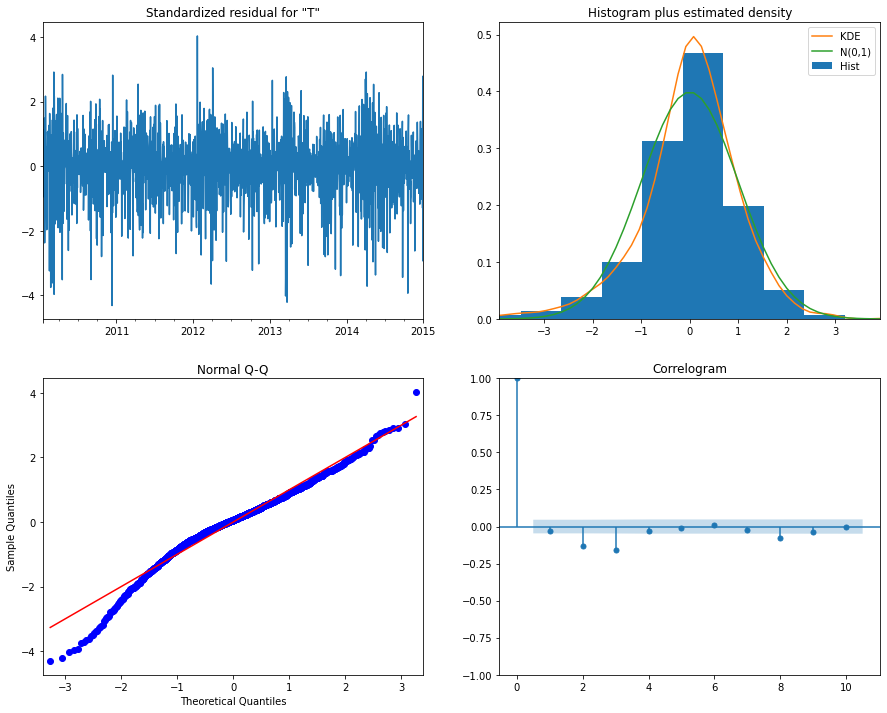

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [10]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [11]:
d = {"predicted_temp": pred.predicted_mean, "average_temp": df["T2M"]}
res_df = pd.DataFrame(data = d)
res_df.head()

,predicted_temp,average_temp
2010-01-01,0.000000,NaN
2010-01-02,5.105673,NaN
2010-01-03,7.301811,NaN
2010-01-04,4.867266,NaN
2010-01-05,1.046326,NaN


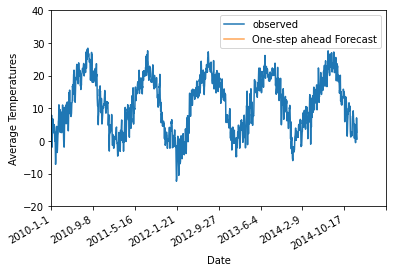

In [16]:
ax = avg_temp['2010-1-1':].plot(label='observed', xlim = [0, 2000], ylim  = [-20, 40])
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Average Temperatures')
plt.legend()

plt.show()

In [13]:
y_forecasted = pred.predicted_mean
y_truth = avg_temp['2010-1-1':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is nan


In [14]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2010-1-1'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

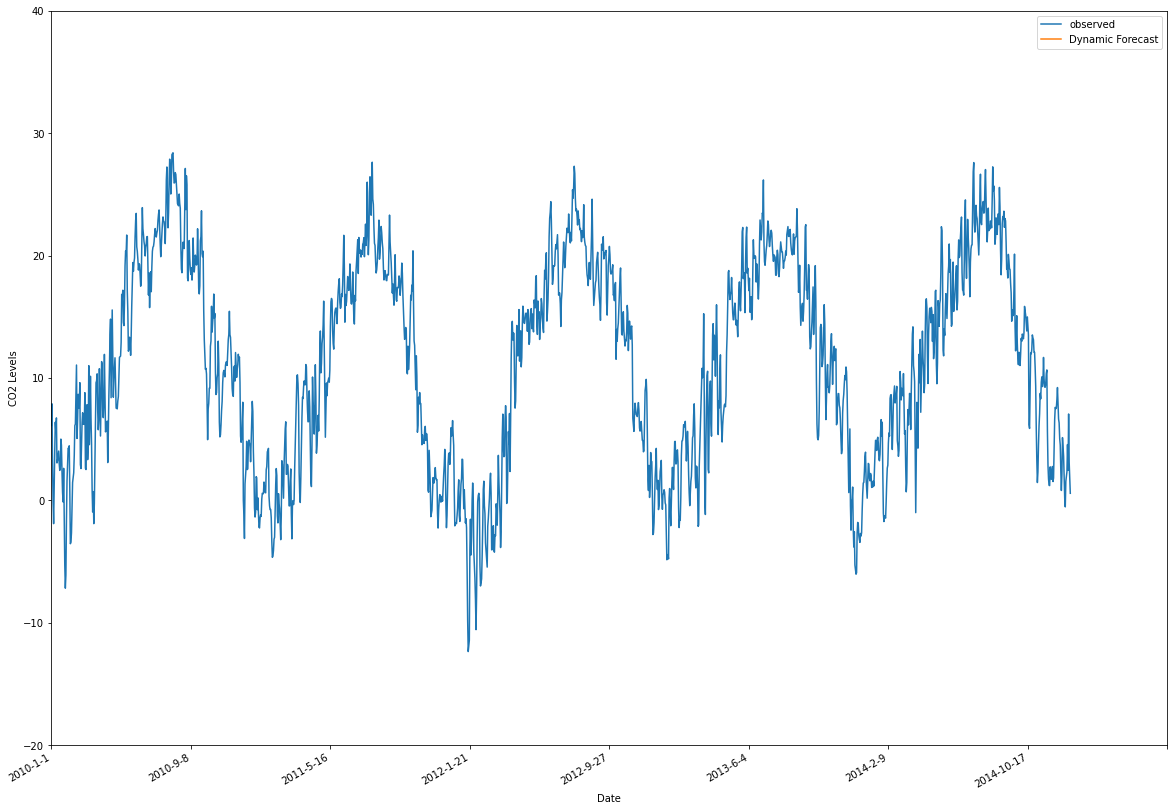

In [15]:
ax = avg_temp['2010-1-1':].plot(label='observed', figsize=(20, 15), xlim = [0,2000], ylim = [-20, 40])
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2010-1-1'), avg_temp.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()